In [1]:
!pip install xgboost

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from xgboost import XGBClassifier
from scipy.stats import ttest_ind, ttest_ind_from_stats
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import itertools

In [3]:
dataset = pd.read_csv('malaicous-url-detector-dataset.csv', low_memory=False)
display(dataset)

,url,label,page_entropy,number_of_script_tags,script_to_body_ratio,length_of_html,number_of_tokens,number_of_sentences,number_of_punctuations,number_of_capitalizations,...,number_of_fragments,is_encoded,num_encoded_char,number_of_subdirectories,number_of_periods,has_client_in_string,has_admin_in_string,has_server_in_string,has_login_in_string,get_tld
0,http://edilsimsrl.net/excel/order/adobeCom/667...,1,4.625598,0,0.000000,315,41,4,8,43,...,0,0,0,5,1,0,0,0,0,net
1,http://leverdistribuidora.com.br/images/custom...,1,4.625598,0,0.000000,315,41,4,8,43,...,0,0,0,5,3,0,0,0,0,br
2,http://rsthomas.net/T/image.htm,1,3.974875,0,0.000000,48,3,2,1,2,...,0,0,0,3,2,0,0,0,0,net
3,http://162.144.84.82/~tdsecureupdate/Tdbank.co...,1,4.848084,0,0.000000,10133,427,60,640,1766,...,0,0,0,4,5,0,0,0,0,82
4,http://162.144.84.82/~tdsecureupdate/Tdbank.co...,1,4.847764,0,0.000000,10133,427,60,640,1766,...,0,0,0,4,5,0,0,0,1,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59335,http://chemistry.missouri.edu/,0,4.749841,9,0.016681,20023,1006,112,2209,283,...,0,0,0,2,2,0,0,0,0,edu
59336,http://chemistry.technion.ac.il/seymour_schuli...,0,5.046173,0,0.000000,568,49,11,42,33,...,0,0,0,2,4,0,0,0,0,il
59337,http://chemistrydaily.com/chemistry/University...,0,4.362936,0,0.000000,150,9,1,0,2,...,0,0,0,3,1,0,0,0,0,com
59338,http://chemistrydaily.com/chemistry/chemistryd...,0,4.362936,0,0.000000,150,9,1,0,2,...,0,0,0,3,2,0,0,0,0,com


In [4]:
#malaicous-url datasets
mal_df = dataset[dataset['label']==1]
non_mal_df = dataset[dataset['label'] == 0]
#display(mal_df)
#display(non_mal_df)

In [5]:
def get_mean(mal_df, non_mal_df, columns):
    mean_diff = []
    for column in columns:
        #diff = (x - x.mean())/x.std()
        mean_diff.append(mal_df[column].mean() - non_mal_df[column].mean())
    return {'column_names': columns, 'mean_difference':mean_diff}

features_list = ['page_entropy', 'number_of_script_tags', 'script_to_body_ratio', 'length_of_html', 'number_of_tokens',\
                'number_of_sentences', 'number_of_punctuations', 'number_of_capitalizations', 'average_number_of_tokens_in_sentence', \
                 'number_of_html_tags', 'number_of_hidden_tags', 'number_of_iframes', \
                'number_of_objects', 'number_of_embeds', 'number_of_hyperlinks', 'number_of_whitespaces', 'number_of_included_elements', \
                'number_of_suspicious_elements', 'number_of_double_documents', 'number_of_eval_functions', 'average_script_length', \
                'average_script_entropy', 'number_of_suspicious_functions']

#print_mean(mal_df, non_mal_df, features_list)

In [6]:
dict_1 = get_mean(mal_df, non_mal_df, features_list)
graph_content_df = pd.DataFrame.from_dict(dict_1)
x = graph_content_df.loc[:, ['mean_difference']]
#display(x)
graph_content_df['mean_difference_std'] = (x - x.mean())/x.std()
graph_content_df['colors'] = ['green' if x < 0 else 'red' for x in graph_content_df['mean_difference_std']]
graph_content_df.sort_values('mean_difference_std', inplace=True)
graph_content_df.reset_index(drop=True, inplace=True)
#display(graph_content_df)

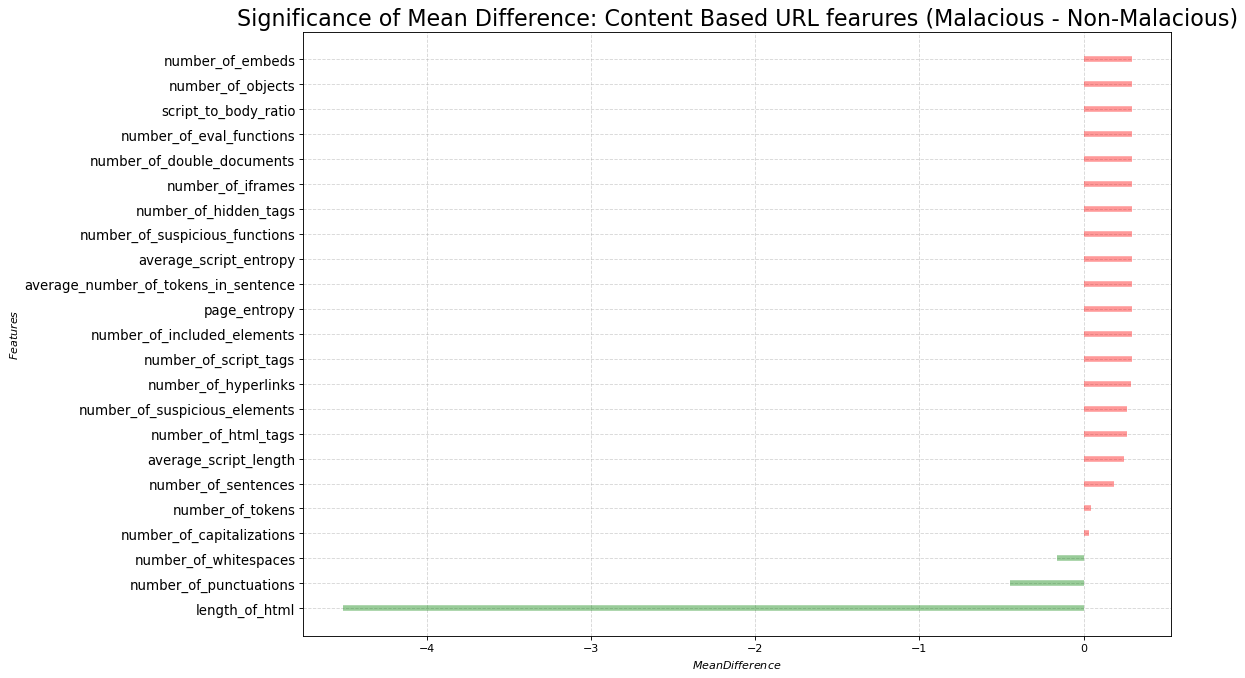

In [7]:
#Draw plot
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=graph_content_df.index, 
           xmin=0, 
           xmax=graph_content_df.mean_difference_std, 
           color=graph_content_df.colors, 
           alpha=0.4, 
           linewidth=5)

# Decorations
plt.gca().set(ylabel='$Features$', xlabel='$Mean Difference$')
plt.yticks(graph_content_df.index, graph_content_df.column_names, fontsize=12)
plt.title('Significance of Mean Difference: Content Based URL fearures (Malacious - Non-Malacious)', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [8]:
#create dummies from TLD column
tldmat = pd.get_dummies(dataset['get_tld'])
#display(tldmat)

##label new dummies matrix
tldmat['tag'] = dataset['label']

### subset malicious and benign sampls
tldmal = tldmat[tldmat['tag'] == 1]
tldben = tldmat[tldmat['tag'] == 0]

dd = []
for i in tldmat.columns[:-1]:
    md = np.mean(tldmal[i]) - np.mean(tldben[i])
    y = ttest_ind(tldmal[i], tldben[i])
    d2 = [i, md, y[1]]
    dd.append(d2)
    
dd = pd.DataFrame(dd)
dd.columns = ['Feature', 'Mean_Difference', 'P_Value']
dd = dd.sort_values(['Mean_Difference', 'P_Value'], ascending=[False, True])


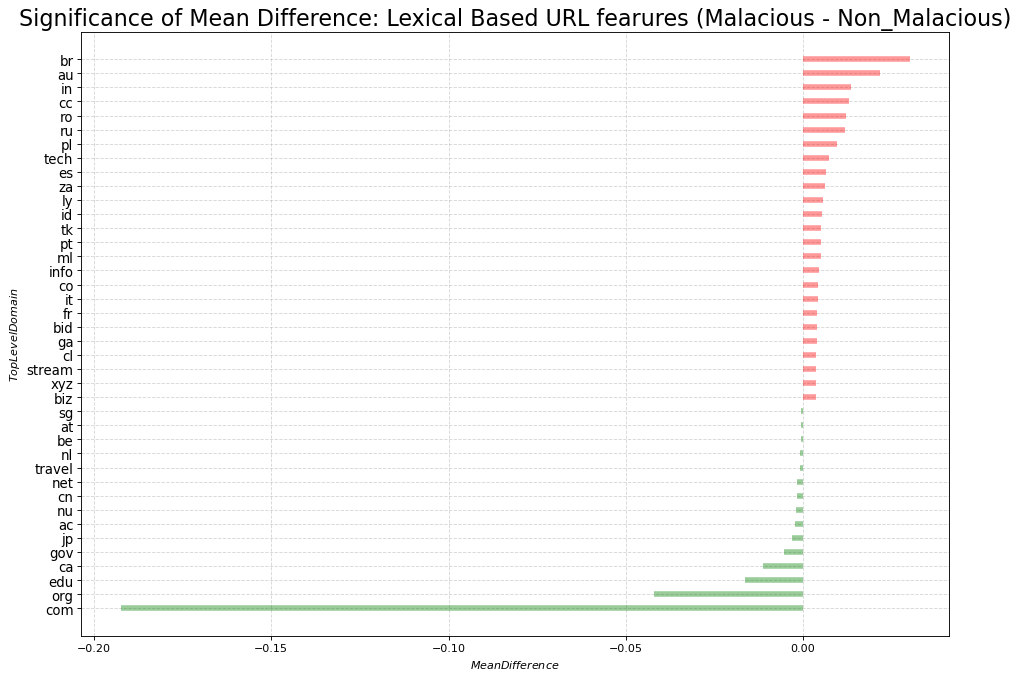

In [9]:
plot_df = pd.concat([dd.tail(15), dd.head(25)])
plot_df['colors'] = ['green' if x < 0 else 'red' for x in plot_df['Mean_Difference']]
plot_df.sort_values('Mean_Difference', inplace=True)
plot_df.reset_index(inplace=True)
#plot_df = plot_df.sort_values(['Mean_Difference', 'P_Value'], ascending=[False, True])
#display(plot_df)

#Draw plot
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=plot_df.index, xmin=0, xmax=plot_df.Mean_Difference, color=plot_df.colors, alpha=0.4, linewidth=5)

# Decorations
plt.gca().set(ylabel='$Top Level Domain$', xlabel='$Mean Difference$')
plt.yticks(plot_df.index, plot_df.Feature, fontsize=12)
plt.title('Significance of Mean Difference: Lexical Based URL fearures (Malacious - Non_Malacious)', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.show()


In [10]:
lst = []
for column in dataset.columns:
    if dataset[column].dtype == 'object':
        lst.append(column)


lst.remove('url')
lst.append('num_subdomains')
#lst.append('lifespan')
display(lst)

['creation_date',
 'expiration_date',
 'recent_update',
 'registrar',
 'registration_country',
 'host_country',
 'open_ports',
 'isp',
 'get_tld',
 'num_subdomains']

In [11]:
dataset.sample(frac=1).reset_index(drop=True, inplace=True)
dataset = dataset.drop(lst, axis=1)
display(dataset)

,url,label,page_entropy,number_of_script_tags,script_to_body_ratio,length_of_html,number_of_tokens,number_of_sentences,number_of_punctuations,number_of_capitalizations,...,number_of_parameters,number_of_fragments,is_encoded,num_encoded_char,number_of_subdirectories,number_of_periods,has_client_in_string,has_admin_in_string,has_server_in_string,has_login_in_string
0,http://edilsimsrl.net/excel/order/adobeCom/667...,1,4.625598,0,0.000000,315,41,4,8,43,...,0,0,0,0,5,1,0,0,0,0
1,http://leverdistribuidora.com.br/images/custom...,1,4.625598,0,0.000000,315,41,4,8,43,...,0,0,0,0,5,3,0,0,0,0
2,http://rsthomas.net/T/image.htm,1,3.974875,0,0.000000,48,3,2,1,2,...,0,0,0,0,3,2,0,0,0,0
3,http://162.144.84.82/~tdsecureupdate/Tdbank.co...,1,4.848084,0,0.000000,10133,427,60,640,1766,...,0,0,0,0,4,5,0,0,0,0
4,http://162.144.84.82/~tdsecureupdate/Tdbank.co...,1,4.847764,0,0.000000,10133,427,60,640,1766,...,0,0,0,0,4,5,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59335,http://chemistry.missouri.edu/,0,4.749841,9,0.016681,20023,1006,112,2209,283,...,0,0,0,0,2,2,0,0,0,0
59336,http://chemistry.technion.ac.il/seymour_schuli...,0,5.046173,0,0.000000,568,49,11,42,33,...,0,0,0,0,2,4,0,0,0,0
59337,http://chemistrydaily.com/chemistry/University...,0,4.362936,0,0.000000,150,9,1,0,2,...,0,0,0,0,3,1,0,0,0,0
59338,http://chemistrydaily.com/chemistry/chemistryd...,0,4.362936,0,0.000000,150,9,1,0,2,...,0,0,0,0,3,2,0,0,0,0


In [13]:
X = dataset.iloc[:, 2:].values
y = dataset.iloc[:, 1].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=5)

In [56]:
model = XGBClassifier(booster = 'gbtree',
                      reg_lambda = 1,
                      reg_alpha = 0,
                      eval_metric = 'error',
                      objective = 'binary:logistic',
                      n_estimators= 200)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))


score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

C:\Users\singh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      8263
           1       0.94      0.91      0.93      3605

    accuracy                           0.96     11868
   macro avg       0.95      0.94      0.95     11868
weighted avg       0.96      0.96      0.96     11868

accuracy:   0.956


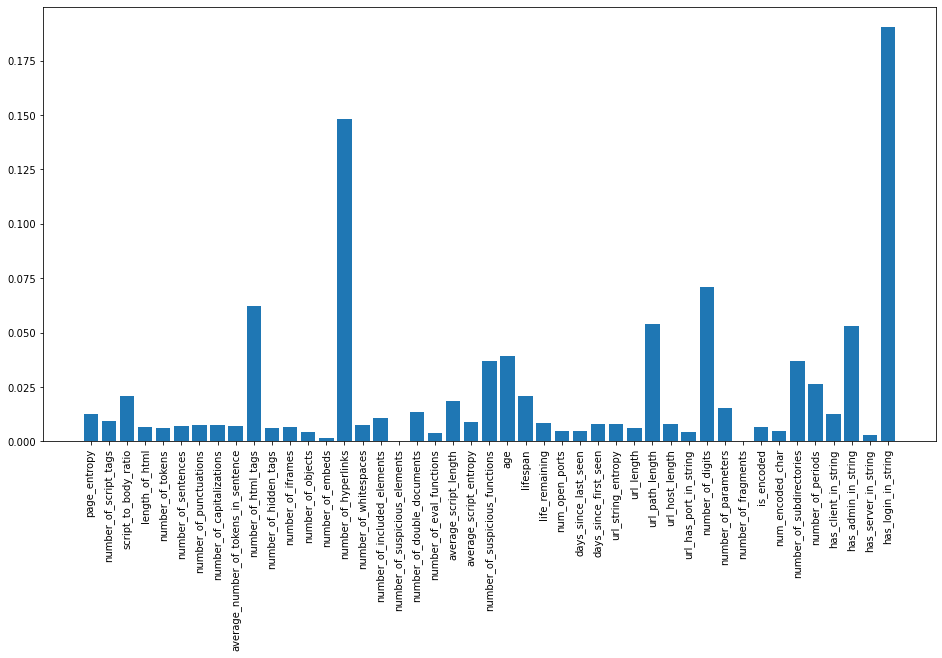

In [57]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.bar(dataset.columns[2:], model.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

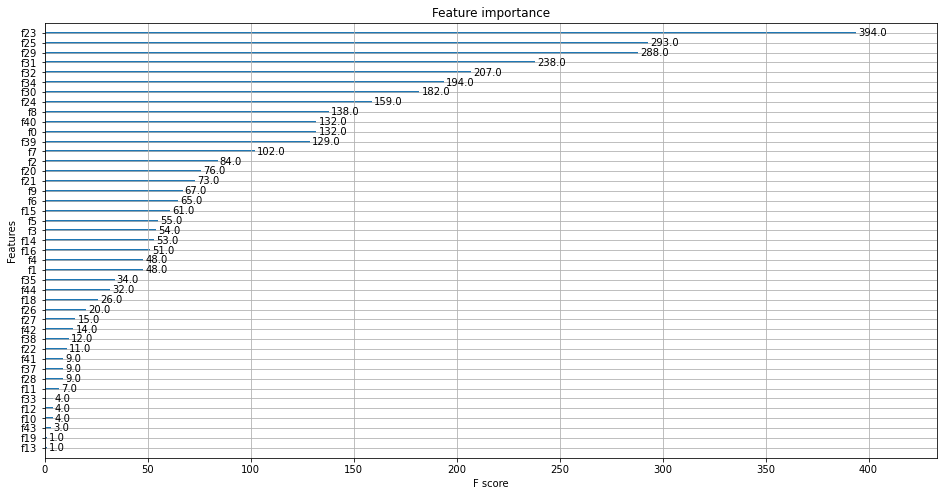

In [143]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model)
pyplot.show()

In [61]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


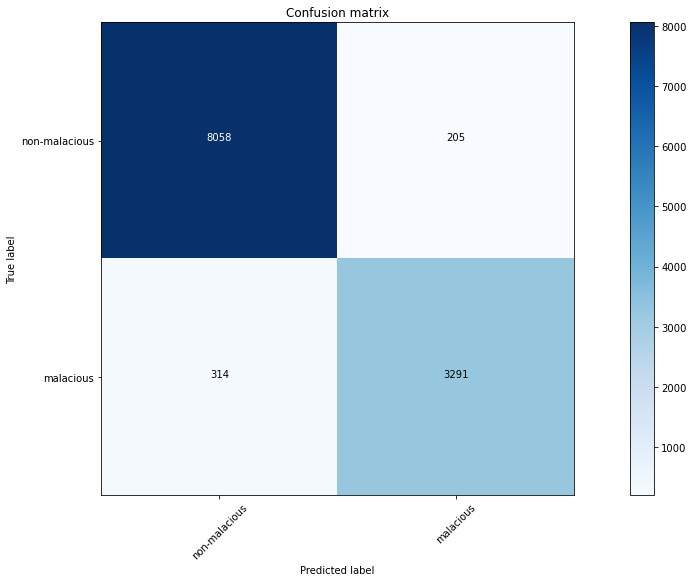

In [62]:
cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
plot_confusion_matrix(cm,classes=['non-malacious', 'malacious'])

In [155]:
import joblib
joblib.dump(model, 'malacious-url-classifier.joblib', compress=3)

['malacious-url-classifier.joblib']